In [1]:
import sys
sys.path.append("G:/DREAM/from_github/PAMFluo")  # path contains python_file.py

from VoltageIntensityClass import VoltageIntensity
import pandas as pd
import numpy as np
import alienlab.utils
import matplotlib.pyplot as plt
from tkinter.filedialog import askopenfilename, askopenfilenames, askdirectory
import alienlab.plot
from alienlab.utils import *
from alienlab.regression_func import *
import json
#from VoltageIntensityClass import VoltageIntensity
import os
from scipy import optimize
import glob
import os

from mvgavg import mvgavg

#import pwlf
%matplotlib ipympl
p = alienlab.plot.PlotFigure()
p.extension = ".pdf"
p.date = False
p.save_folder = "G:/DREAM/from_github/thesis/Figures/biophysical_validation/"
p.figsize = (10,5)
p.fontsize = 18
p.fonttick = 12

from collections import OrderedDict

linestyles = OrderedDict(
    [('solid',               (0, ())),
     #('loosely dotted',      (0, (1, 10))),
     ('dotted',              (0, (1, 2))),
     ('densely dotted',      (0, (1, 1))),

     #('loosely dashed',      (0, (5, 10))),
     ('dashed',              (0, (5, 2))),
     ('densely dashed',      (0, (5, 1))),

     #('loosely dashdotted',  (0, (3, 10, 1, 10))),
     ('dashdotted',          (0, (3, 2, 1, 2))),
     ('densely dashdotted',  (0, (3, 1, 1, 1))),

     #('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('dashdotdotted',         (0, (3, 2, 1, 2, 1, 2))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))])
keys = list(linestyles.keys())


In [2]:
direc ="."#askdirectory(initialdir="G:/DREAM/from_github/PAMFluo/Experiments")#
print(direc)

.


In [3]:
level_ref = "G:/DREAM/from_github/PAMFluo/specs/config_black.json"

with open(level_ref, 'r') as file:
    black_level = json.load(file)

    fluo_min = black_level["ai1"][1]
    
    print("minimal level of fluorescsence", fluo_min)
    
    intensity_min = black_level["ai0"][1]
    print("minimal level of intensity",  intensity_min)
        

minimal level of fluorescsence 0.0013973342018303138
minimal level of intensity 0.013942900247945813


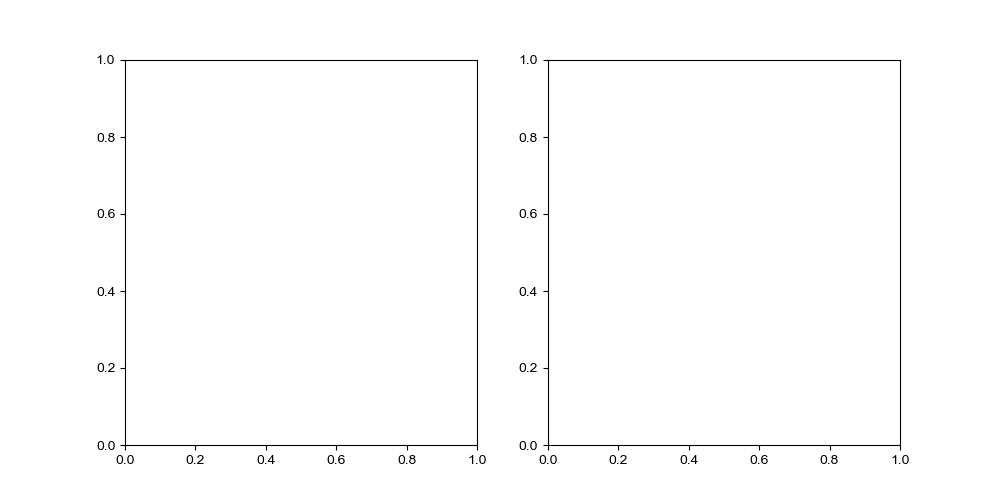

In [4]:
data = {}

fs_curves = []
FD_curves = []
I_curves = []

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for i, exp in enumerate(glob.glob(direc+"/*/")):
    if "IBPC" in exp:
        
        file = glob.glob(exp+ "/*IBPC_pulse.csv*")

        df = pd.read_csv(file[0])
        data[i] = df
        fs_curves.append(df['voltage pulse_mean'])
        FD_curves.append(df['voltage blank_mean'])
        I_curves.append(df['voltage intensity_mean'])

        #FD = FD_curve.mean()
        #I = I_curve.mean()
        #if FD/I > 0: 
        #    plt.plot(I, FD/I, '.')    
        #axs[0][0].loglog(i, FD, '.')
        #axs[0][1].loglog(i, I, '.')
        #axs[0].plot(fs_curves)
        #axs[1].plot(FD_curve/I_curve)

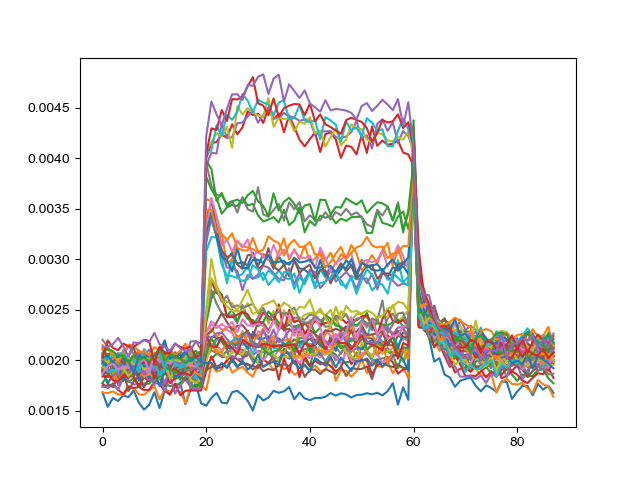

In [5]:
fs_curves = np.array(fs_curves)
FD_curves= np.array(FD_curves)
I_curves = np.array(I_curves)

fs_mean = fs_curves[::2] + fs_curves[1::2]
FD_mean = FD_curves[::2] + FD_curves[1::2]
I_mean = I_curves[::2] + I_curves[1::2]

#fs_mean= 
        
plt.close("all")
plt.figure()
for i in range(len(fs_mean)):
    plt.plot(fs_mean[i])
               

In [6]:
V = VoltageIntensity(folder = "G:/DREAM/from_github/PAMFluo/Experiments/2021-12-16_16_17_bode_diagram")
print(V.get_intensity_voltage('blue', 1, 30/100 )*1e6)
filter_list = np.repeat([3,3, 3, 3, 2, 2, 2, 2, 2, 2, 1, 1,1,0,0], 2)
limits_blue = np.repeat([0, 50, 95, 150, 34, 61, 82, 140, 190, 420, 140, 170, 330, 40, 50], 2)

16.14289597016012



# FD and FD/I

# PAM param

In [7]:
from statsmodels.regression import linear_model

    
def regression_affine(X, Y, details = True):
        Xreg = add_constant(X) #Add a constant to fit tan affine model

        model = linear_model.OLS(Y, Xreg) #Linear regression
        results = model.fit()
        [b, a] = results.params #parameters of the affine curve
        Yreg = a*X + b #regression curve

        return Yreg, [a, b], results.summary()

def regression_lineaire(X, Y, details = True):

        model = linear_model.OLS(Y, X) #Linear regression
        results = model.fit()
        [a] = results.params #parameters of the affine curve
        Yreg = a*X #regression curve

        return Yreg, a, results.summary()


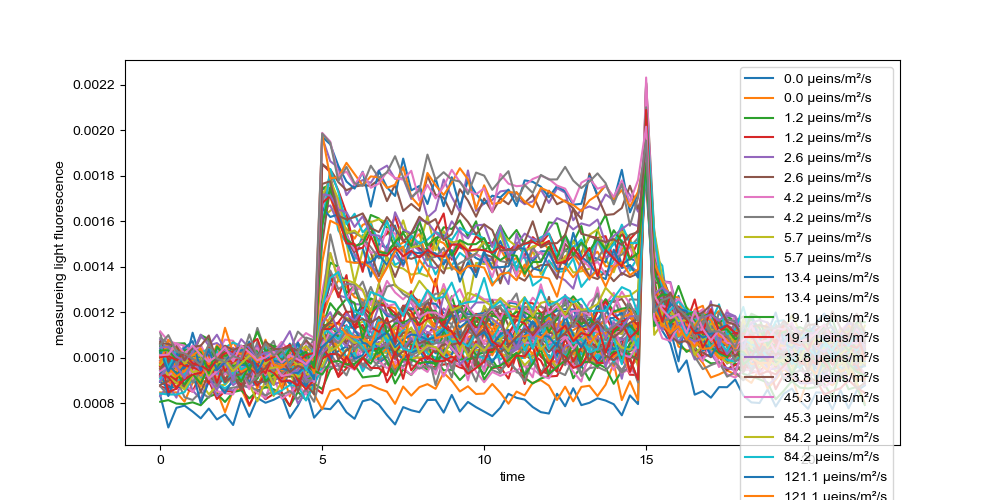

In [8]:
fm = []
f0 = []
fs = []
fs1 = []
fd = []
fd1 = []
trace = []
trace_direct = []
intensity_mppc = []
intensity_exp = []
black = []
black_I = []
N = len(limits_blue)

plt.figure(figsize = (10, 5))
for i, exp in enumerate(glob.glob(direc+"/*/")):
    if "logs" not in exp and "eliora" not in exp and i%N<(N-4):
    #if limits_blue[i%N]!=0 and i%N < N-4:
        if limits_blue[i%N] == 0:
            iv = 0
        else:
            iv=  V.get_intensity_voltage('blue', filter_list[i%N], limits_blue[i%N]/100 )*1e6
        file = glob.glob(exp+ "/*IBPC_pulse.csv*")
        df = pd.read_csv(file[0])
        x = df['pulse number pulse_mean']
        y = df['voltage pulse_mean']
        z = df['voltage blank_mean']
        I = df['voltage intensity_mean']
        plt.plot(x/4, y, label = "%0.1f µeins/m²/s"%iv)
        plt.xlabel("time")
        plt.ylabel('measureing light fluorescence')
        
        trace.append(y)
        trace_direct.append(z)
        fm.append(y[60])
        f0.append(np.mean(y[0:15]))
        fs.append(np.mean(y[50:59]))
        fd.append(np.mean(z[50:59]))
        fs1.append(np.mean(y[21:40]))
        fd1.append(np.mean(z[21:40]))
        intensity_mppc.append(np.mean(I[50:59]))
        
        black.append(np.mean(z[0:10]))
        intensity_exp.append(iv)
        black_I.append(np.mean(I[0:10]))
plt.legend()
plt.show()
black = np.array(black)
f0 = np.array(f0)- black
fs = np.array(fs) - black
fm = np.array(fm) - black
intensity_mppc = np.array(intensity_mppc) - np.array(black_I)

intensity_mppc= np.array(intensity_mppc)
intensity_exp = np.array(intensity_exp)

fs1 = np.array(fs1) - black
fd1 = np.array(fd1) - black
fd = np.array(fd) - black


intensities, positions = np.unique(intensity_exp, return_inverse=True)
dic_val = {}
intensity_avg = np.copy(intensity_mppc)*0
for i, intens in enumerate(intensities):
    dic_val[intens] = []
    for k, pos in enumerate(positions): 
        if pos==i:
            dic_val[intens].append(intensity_mppc[k])
            
for i, intens in enumerate(intensities):
    for k, pos in enumerate(positions): 
        if pos==i:
            intensity_avg[k] = np.mean(dic_val[intens])

0.0001688932440144143


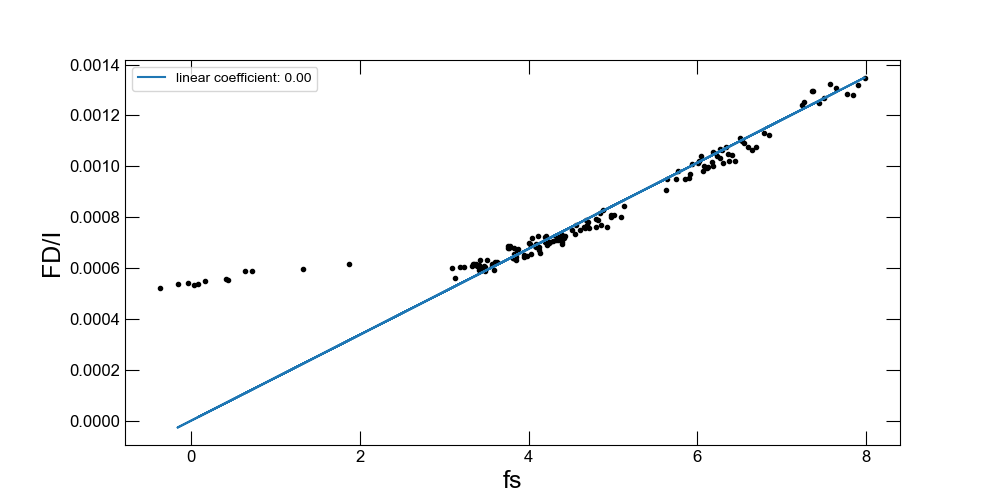

In [9]:
fd= np.array(fd)
fd1 = np.array(fd1)
fs = np.array(fs)
fs1 = np.array(fs1)
fm = np.array(fm)
f0 = np.array(f0)
#plt.plot(FDI/FDI.max())
plt.figure(figsize=p.figsize)
#plt.plot(intensity_exp, fs, "bo", label = 'decay')
#plt.plot(intensity_exp, fs1, 'ko', label = "bump")
#X = fd1/intens
#Y = fs1
#X = X/X.max()
#Y = Y/Y.max()
#plt.plot(X, Y, 'k.', label = "bump")
X = fd/intensity_mppc
Y = fs
X = X#/X.max()
Y = Y#/Y.max()
plt.plot(X, Y, 'k.')#, label = "before saturating")
#plt.plot(fd1/intensity_mppc, fs1, 'k.', label = "bump")

X = fd1/intensity_mppc
Y = fs1
X = X#/X.max()
Y = Y#/Y.max()
plt.plot(X, Y, 'k.')#, label = "after saturating")
#plt.plot(fd/intensity_mppc, fs, 'k.', label = "before fm'")

Yreg, a, r = regression_lineaire(X, Y, details = True)
plt.plot(X, Yreg, label  = "linear coefficient: %0.2f"%a)

#Yreg, a, r = regression_affine(fd/intensity_mppc, fs, details = True)
print(a)
#plt.plot(fd/intensity_mppc, Yreg, label = "affine")
Yreg, a, r = regression_lineaire(fd/intensity_mppc, fs, details = True)
#plt.plot(fd/intensity_mppc, Yreg, label  = "lineaire")

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )

plt.ylabel("FD/I", fontsize=p.fontsize)
plt.xlabel('fs', fontsize=p.fontsize)
plt.legend()
plt.savefig(p.save_folder + "/direct_fluo_vs_fs.pdf")

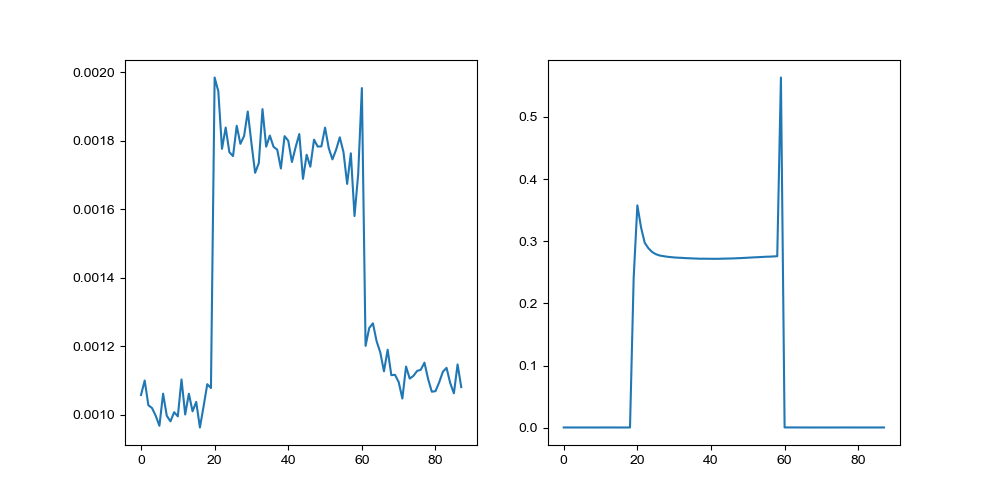

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(y)

axs[1].plot(z)
plt.show()

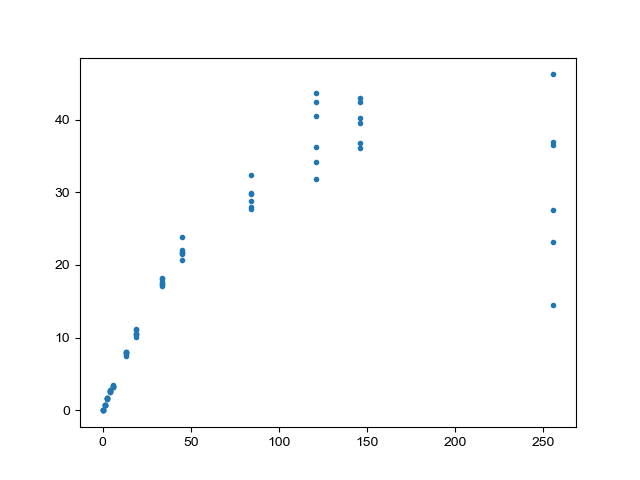

In [11]:
plt.figure()
plt.plot(intensity_exp, (fm-fs)/fm*intensity_exp, ".")

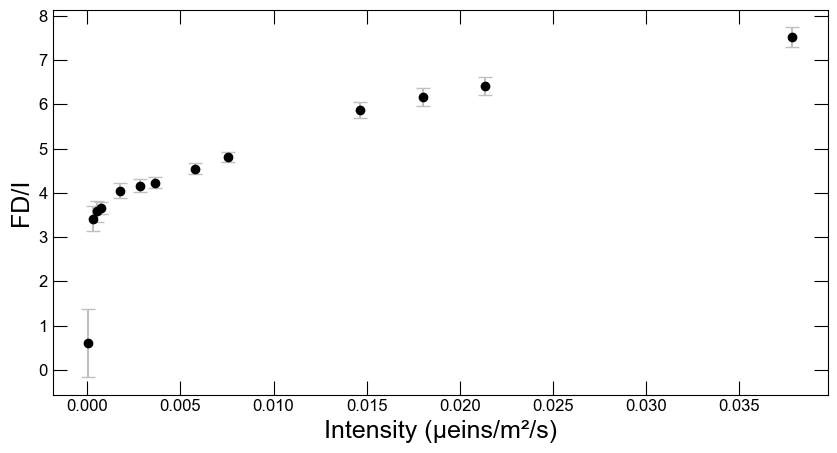

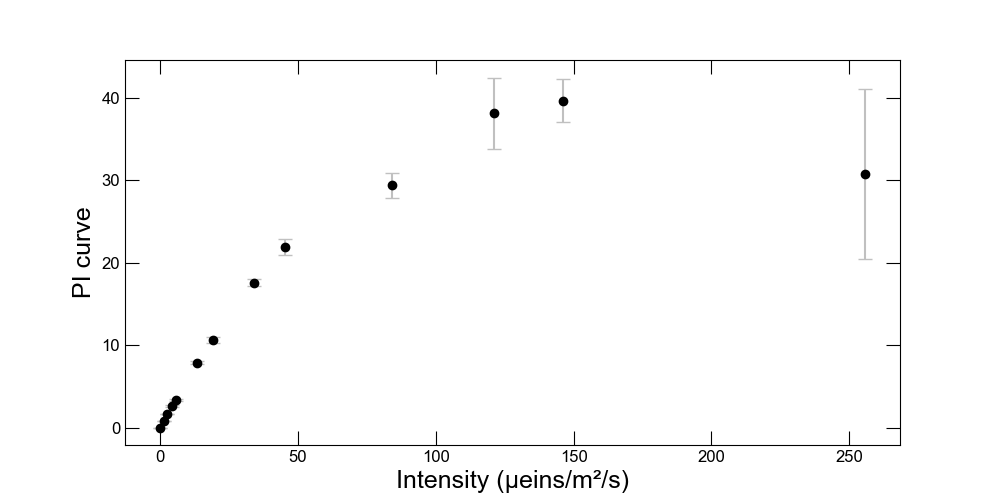

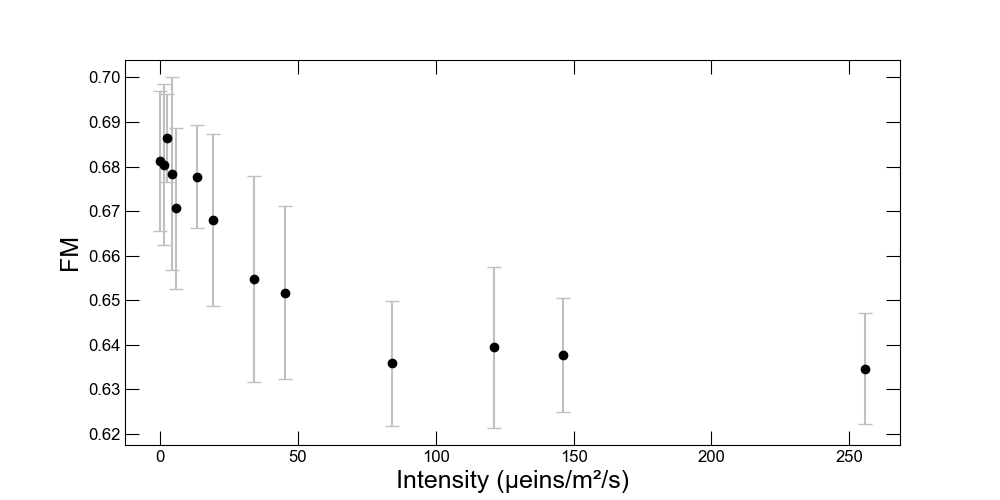

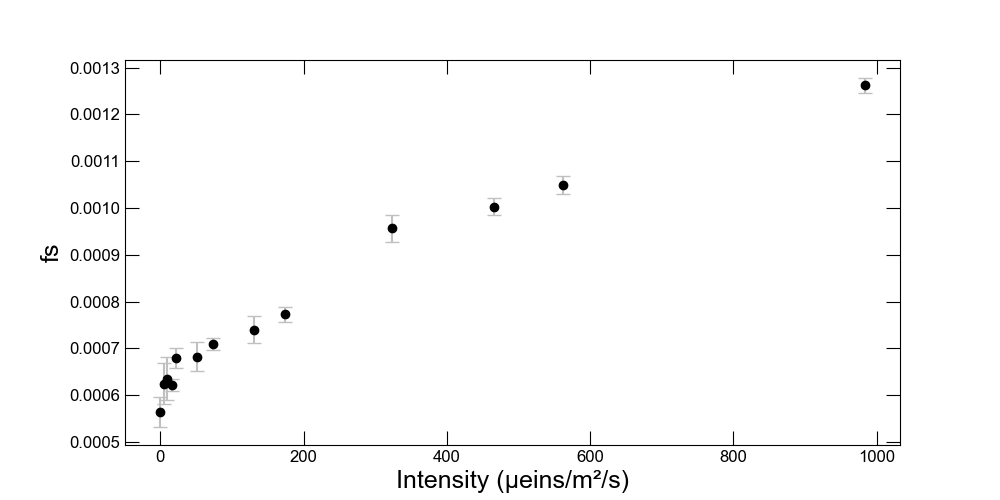

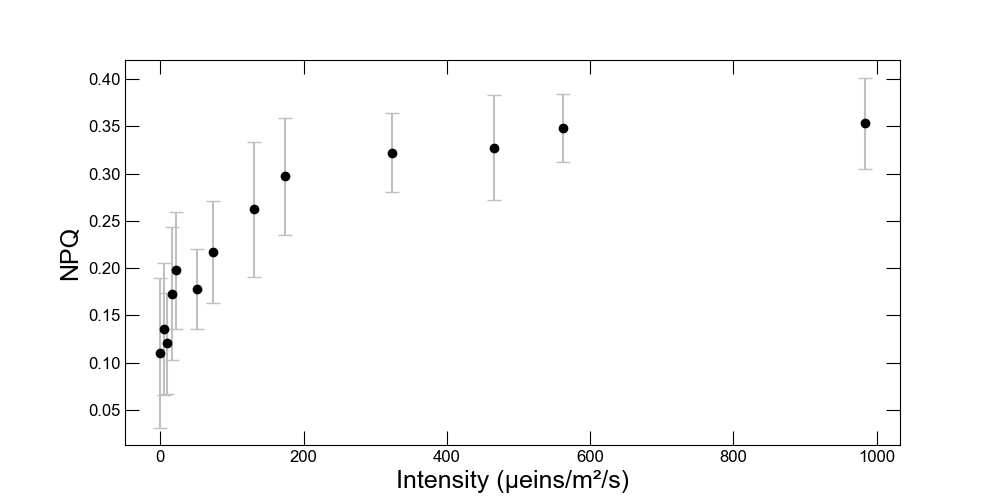

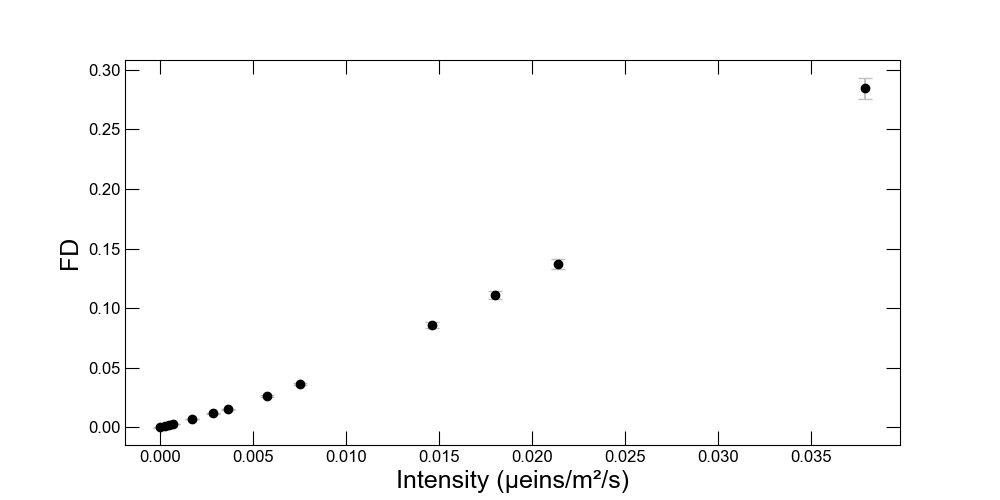

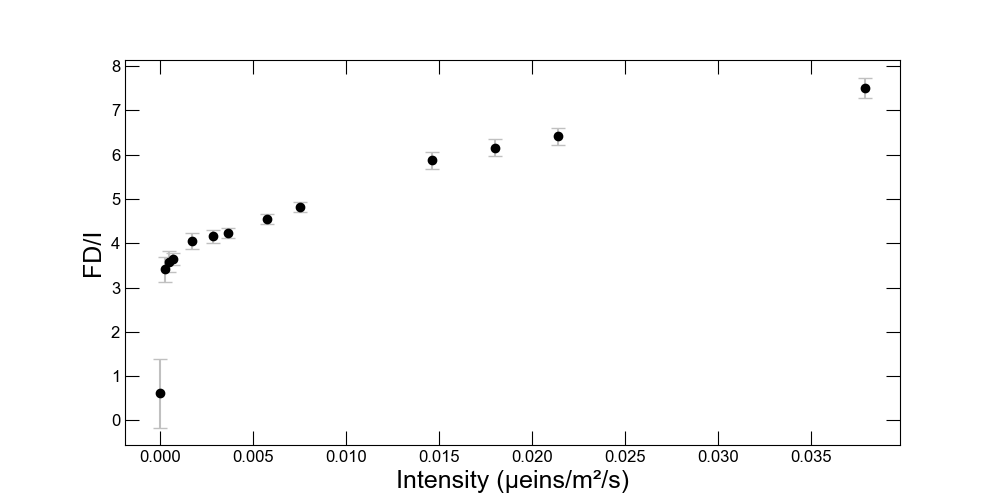

In [12]:

def unite_units(intensity_exp, ratio_val, ylabel):
    intensities, positions = np.unique(intensity_exp, return_inverse=True)
    dic_val = {}
    for i, intens in enumerate(intensities):
        dic_val[intens] = []
        for k, pos in enumerate(positions): 
            if pos==i:
                dic_val[intens].append(ratio_val[k])
    
    fig = plt.figure(figsize = p.figsize)                           
    for j, k in enumerate(dic_val.keys()):
        m = np.mean(dic_val[k])
        s = np.std(dic_val[k])
        if k==0:
            plt.errorbar(k, m, s, capsize=5, ecolor="silver", fmt='--ok')
        else: 
            plt.errorbar(k, m, s, capsize=5, ecolor="silver",  fmt='--ok')
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
    plt.xlabel("Intensity (µeins/m²/s)", fontsize=p.fontsize)
    plt.ylabel(ylabel, fontsize = p.fontsize)
    return fig

def unite_units_dual(intensity_exp, ratio_val, eintensity, eratio_val, ylabel, limin, limax):
    intensities, positions = np.unique(intensity_exp, return_inverse=True)
    dic_val = {}
    for i, intens in enumerate(intensities):
        dic_val[intens] = []
        for k, pos in enumerate(positions): 
            if pos==i:
                dic_val[intens].append(ratio_val[k])
                
    intensities, positions = np.unique(eintensity, return_inverse=True)
    edic_val = {}
    for i, intens in enumerate(intensities):
        edic_val[intens] = []
        for k, pos in enumerate(positions): 
            if pos==i:
                edic_val[intens].append(eratio_val[k])

    fig = plt.figure(figsize = p.figsize)                           
    for j, k in enumerate(dic_val.keys()):
        m = np.mean(dic_val[k])
        s = np.std(dic_val[k])
        if j==0:
            plt.errorbar(k, m, s, capsize=5, ecolor="silver", fmt='--ok', label = "ENS")
        else: 
            plt.errorbar(k, m, s, capsize=5, ecolor="silver", fmt='--ok')

    for j, k in enumerate(edic_val.keys()):
        if k<1700:
            m = np.mean(edic_val[k])
            s = np.std(edic_val[k])
            if j==0:
                plt.errorbar(k, m, s, capsize=5,  ecolor="silver", fmt='--+k', label = "IBPC")
            else: 
                plt.errorbar(k, m, s, capsize=5, ecolor="silver", fmt='--+k') 

    plt.ylim(limin, limax)
    plt.legend()
    
    ax = plt.gca()
    ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
    plt.xlabel("Intensity (µeins/m²/s)", fontsize=p.fontsize)
    plt.ylabel(ylabel, fontsize = p.fontsize)
    return fig


l480 = 100
l550 = 26
corrintensity = np.array(intensity_exp)*l480/l550
unite_units(intensity_exp, (fm-fs)/fm*intensity_exp, ylabel = "PI curve")
unite_units(intensity_exp, (fm-f0)/fm, ylabel = "FM")
unite_units(np.array(intensity_exp)*l480/l550, fs, ylabel = "fs")
unite_units(corrintensity, (fm[0]-fm)/fm, ylabel = "NPQ")
unite_units(intensity_avg, fd, ylabel = "FD")
unite_units(intensity_avg, fd/intensity_mppc, ylabel = "FD/I")

## DATA ELIORA

In [13]:
exp = np.genfromtxt("validation_eliora/2021-12-17 IBPC aprem.csv", delimiter = ",", skip_header = 1)
#plt.figure()
time = exp[:,0]
efm = []
ef0 = []
efs = []
efs1 = []
efd = []
etrace = []

t,s =exp.shape

eintensity = [18, 18, 40, 40, 90, 90, 130, 130, 230, 230, 320, 320, 570, 570, 840, 840, 1000, 1000, 1720, 1720, 3070, 3070, 4210, 4210, 
              4210, 4210, 40,40, 90, 130, 230, 320, 570, 840, 1000, 1720, 1720, 3070, 3070]
for k in range(s-2):#len(intensity), 40):
    signal = exp[:,k+1]
    ef0.append(np.mean(signal[0:3]))
    efs.append(np.mean(signal[45:65]))
    efm.append(signal[70])
    etrace.append(signal)
    #plt.plot(exp[:,0], signal)
    

ef0 = np.array(ef0)
efm = np.array(efm)
efs = np.array(efs)
eintensity = np.array(eintensity)

#plt.figure()

ratio =  (efm-efs)/efs*eintensity
maxi = ratio[ratio==ratio].max()
#plt.plot(eintensity, ratio/maxi, ".")
ratio = (fm-fs)/fm*corrintensity
#plt.plot(corrintensity, ratio/ratio.max() , ".")


### fluo directe

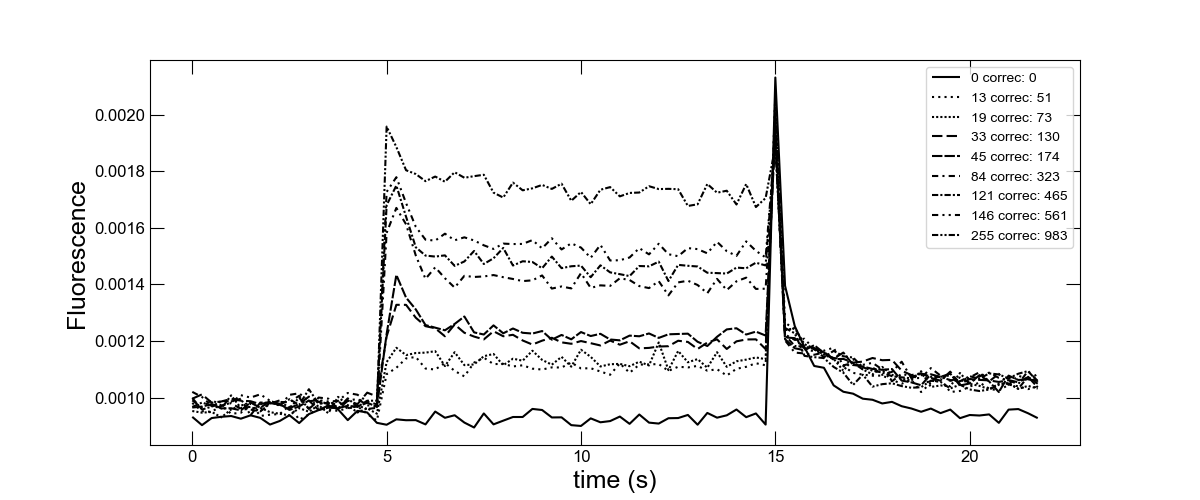

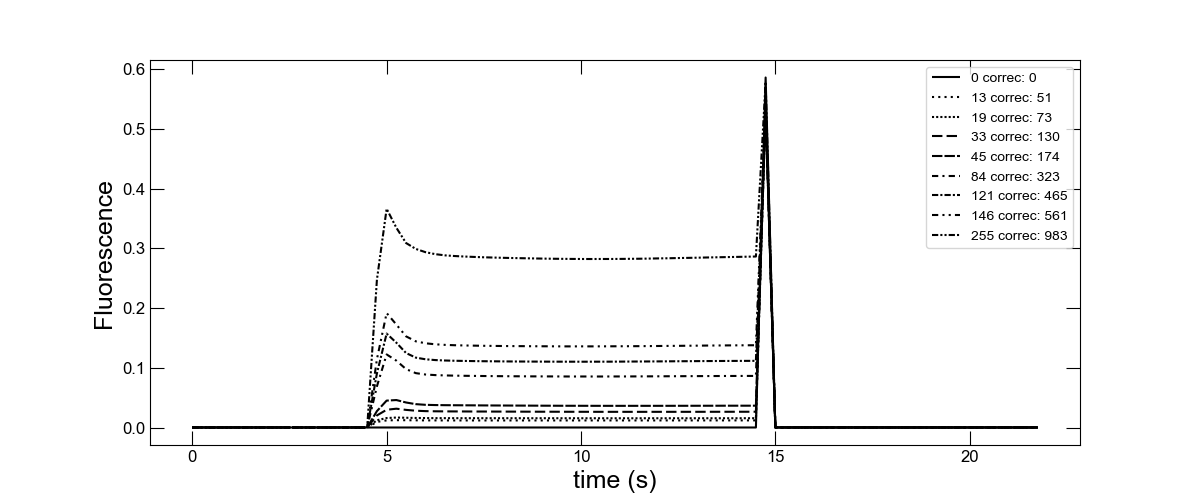

In [14]:
plt.figure(figsize = (12, 5))


keys = list(linestyles.keys())
intensities, positions = np.unique(intensity_exp, return_inverse=True)
dic_val = {}
for i, intens in enumerate(intensities):
    dic_val[intens] = []
    for k, pos in enumerate(positions): 
        if pos==i:
            dic_val[intens].append(trace[k])

            l=0
for j, k in enumerate(dic_val.keys()):
    if k==0 or k>13:
        m = np.mean(np.array(dic_val[k]), axis = 0)
        plt.plot(x/4, m, color = "k", linestyle = linestyles[keys[l]], label = "%d correc: %d"%(k, k*l480/l550))
        l+=1
    
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
plt.xlabel("time (s)", fontsize=p.fontsize)
plt.ylabel("Fluorescence", fontsize = p.fontsize)
plt.legend()    
plt.savefig(p.save_folder + '/compare_ML_ENS.pdf')

plt.figure(figsize = (12,5))


keys = list(linestyles.keys())
intensities, positions = np.unique(intensity_exp, return_inverse=True)
dic_val_direct = {}
for i, intens in enumerate(intensities):
    dic_val_direct[intens] = []
    for k, pos in enumerate(positions): 
        if pos==i:
            dic_val_direct[intens].append(trace_direct[k])

            l=0
            
keys = list(linestyles.keys())
intensities, positions = np.unique(intensity_exp, return_inverse=True)
dic_val_FDI = {}
for i, intens in enumerate(intensities):
    dic_val_FDI[intens] = []
    for k, pos in enumerate(positions): 
        if pos==i:
            dic_val_FDI[intens].append((trace_direct[k] - np.mean(trace_direct[k][0:15]))/(intensity_mppc[k]- intensity_mppc[0]))

            l=0
            
            
for j, k in enumerate(dic_val.keys()):
    if k==0 or k>13:
        m = np.mean(np.array(dic_val_direct[k]), axis = 0)
        plt.plot(x/4, m, color = "k", linestyle = linestyles[keys[l]], label = "%d correc: %d"%(k, k*l480/l550))
        l+=1
    
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
plt.xlabel("time (s)", fontsize=p.fontsize)
plt.ylabel("Fluorescence", fontsize = p.fontsize)
plt.legend()    
plt.savefig(p.save_folder + '/compare_direct_fluo_ENS.pdf')
            

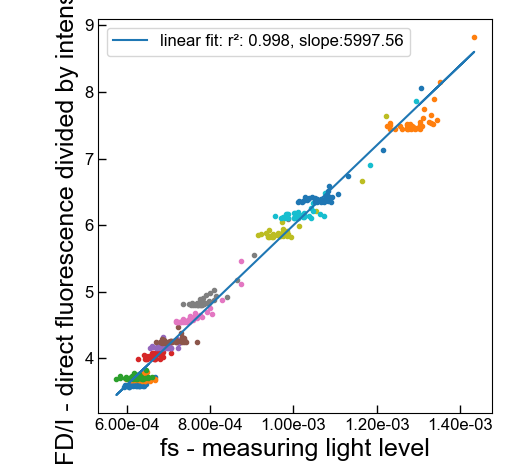

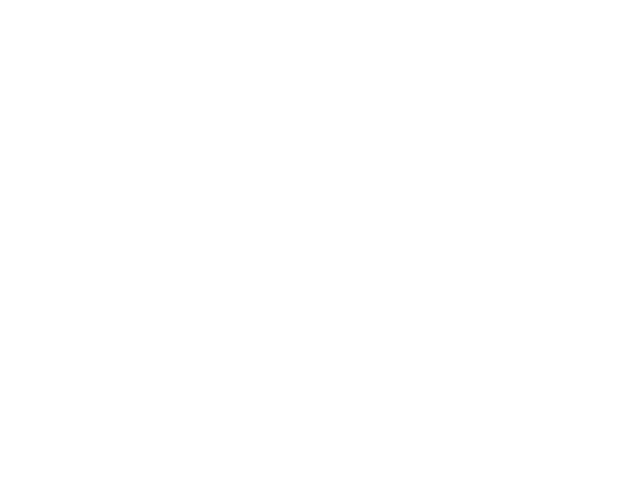

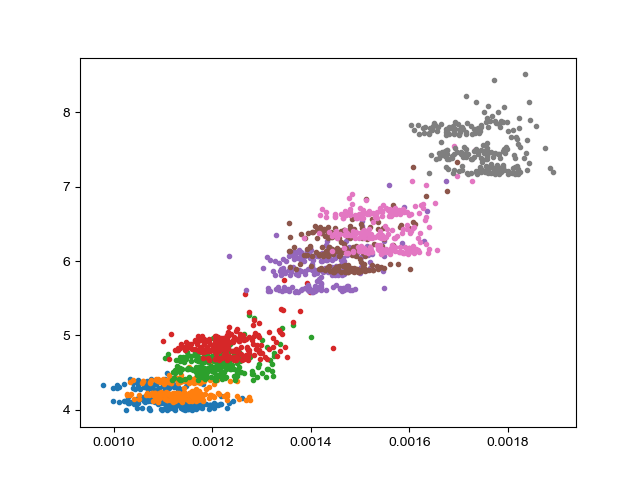

In [15]:
X = []
Y = []

p.figsize = (10,10)
fig = p.set_figure("%0.2e","%d")
for i in dic_val_direct.keys():
    if i>0:
        
        x = np.mean(np.array(dic_val[i])[:, 21:58] - np.expand_dims(np.mean(np.array(dic_val_direct[i])[:, 0:15], axis=1), 1), axis =0)
        y = np.mean(np.array(dic_val_FDI[i])[:, 21:58], axis =0)

        X.append(x)
        Y.append(y)
        plt.scatter(x,y, marker = '.')
X = np.concatenate(X)
Y = np.concatenate(Y)
Yreg, a, r = regression_lineaire(X, Y, details = True)
plt.plot(X, Yreg, label  = "linear fit: r²: 0.998, slope:%0.2f"%a)#print(r)
plt.legend(prop={"size":12})
plt.ylabel("FD/I - direct fluorescence divided by intensity")
plt.xlabel("fs - measuring light level")
p.save_name = "equiv_FD_fs"
p.saving(fig)

    

plt.figure()
for i in dic_val_direct.keys():
    if i>10:
        plt.scatter(np.array(dic_val[i])[:,22:58], np.array(dic_val_FDI[i])[:,22:58], marker = '.')
    

## COMPARE

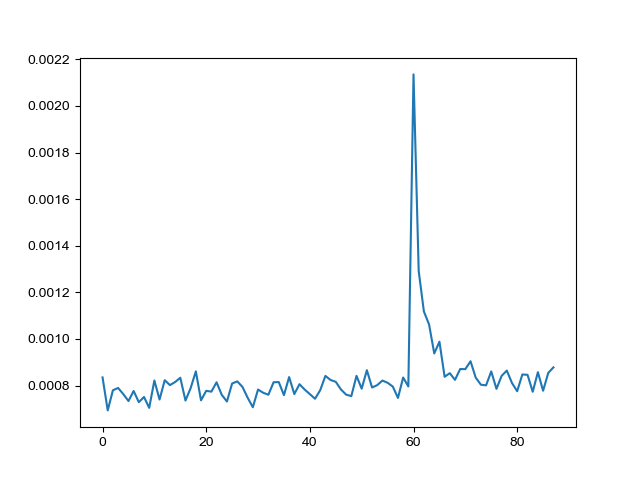

In [50]:
plt.figure()
plt.plot(trace[0])

In [51]:
m.shape

(88,)

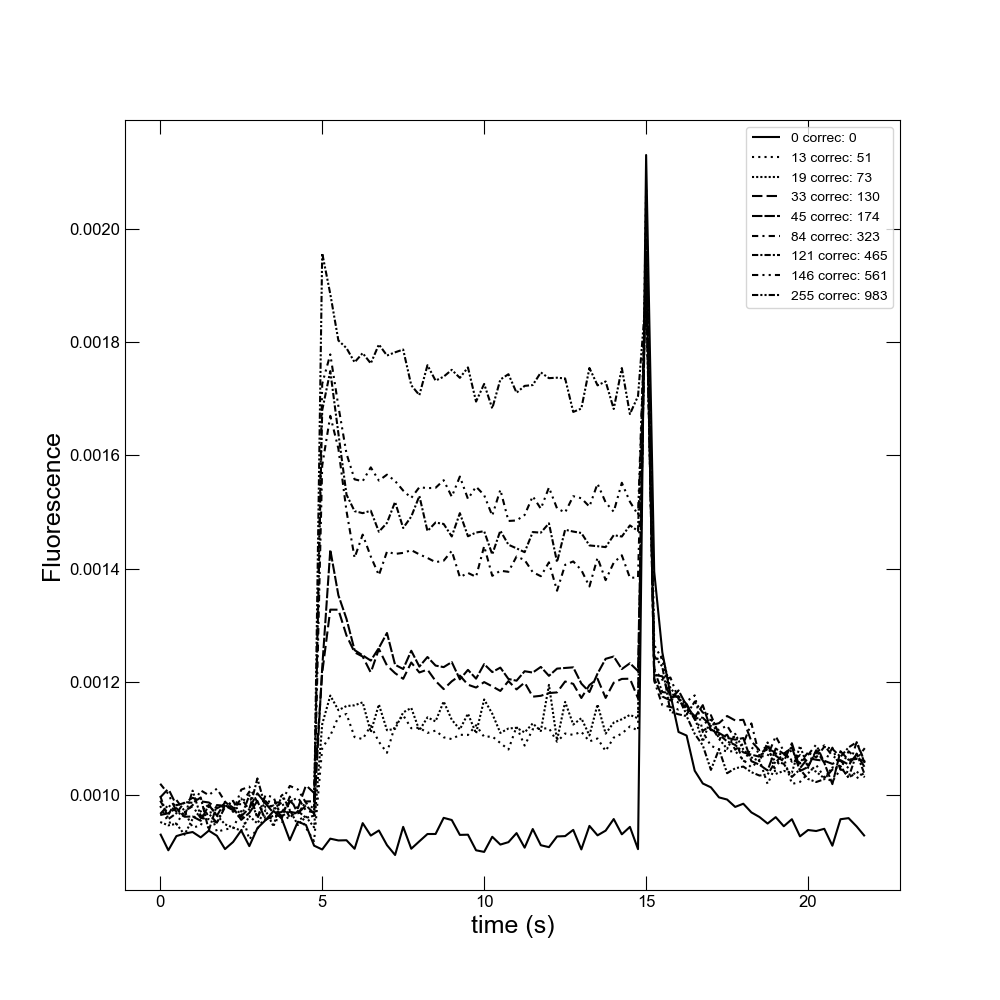

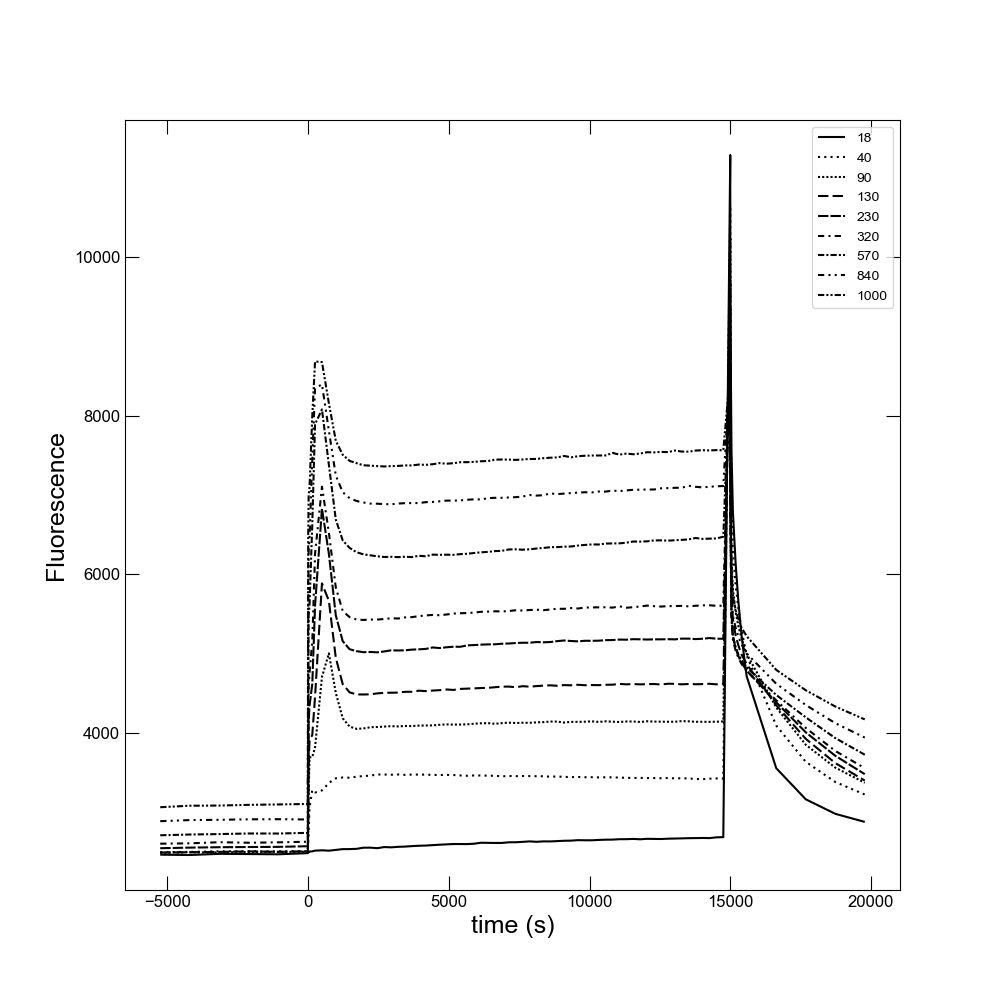

In [52]:
plt.figure(figsize = p.figsize)


keys = list(linestyles.keys())
intensities, positions = np.unique(intensity_exp, return_inverse=True)
dic_val = {}
for i, intens in enumerate(intensities):
    dic_val[intens] = []
    for k, pos in enumerate(positions): 
        if pos==i:
            dic_val[intens].append(trace[k])

            l=0
for j, k in enumerate(dic_val.keys()):
    if k==0 or k>13:
        m = np.mean(np.array(dic_val[k]), axis = 0)
        x = np.linspace(0, len(m)-1, len(m))
        plt.plot(x/4,m, color = "k", linestyle = linestyles[keys[l]], label = "%d correc: %d"%(k, k*l480/l550))
        l+=1
    
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
plt.xlabel("time (s)", fontsize=p.fontsize)
plt.ylabel("Fluorescence", fontsize = p.fontsize)
plt.legend()    
plt.savefig(p.save_folder + '/compare_pulse_ENS.pdf')
            
plt.figure(figsize = p.figsize)

intensities, positions = np.unique(eintensity, return_inverse=True)
dic_val = {}
for i, intens in enumerate(intensities):
    dic_val[intens] = []
    for k, pos in enumerate(positions): 
        if pos==i:
            dic_val[intens].append(etrace[k])

l = 0
for j, k in enumerate(dic_val.keys()):
    if k<=1000:
        m = np.mean(np.array(dic_val[k]), axis = 0)
        plt.plot(exp[:,0], m, color = "k", linestyle = linestyles[keys[l]], label = "%d"%k)
        l+=1
    
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
plt.xlabel("time (s)", fontsize=p.fontsize)
plt.ylabel("Fluorescence", fontsize = p.fontsize)
plt.legend()    
plt.savefig(p.save_folder + '/compare_pulse_IBPC.pdf')


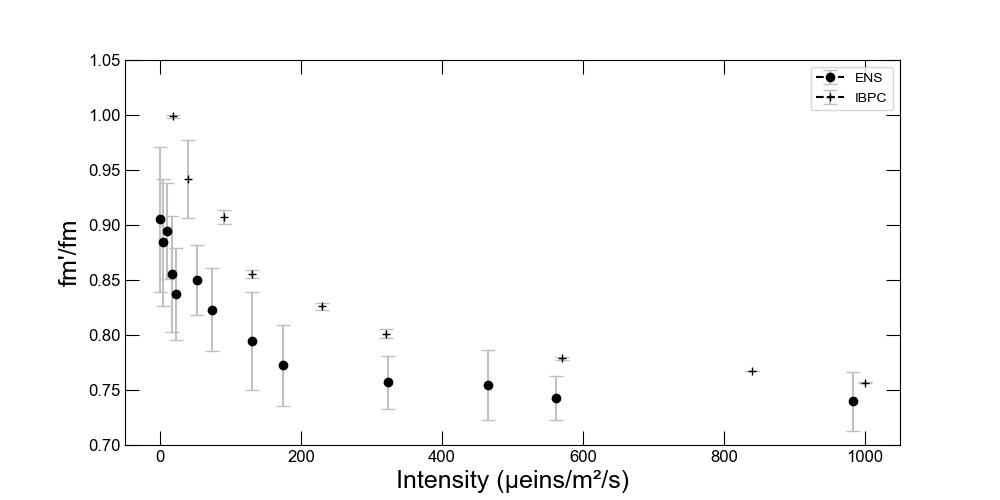

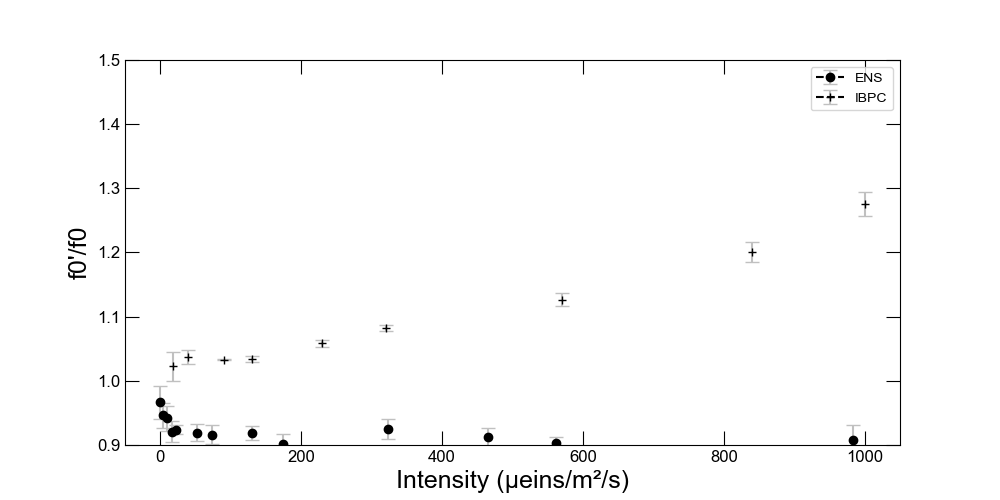

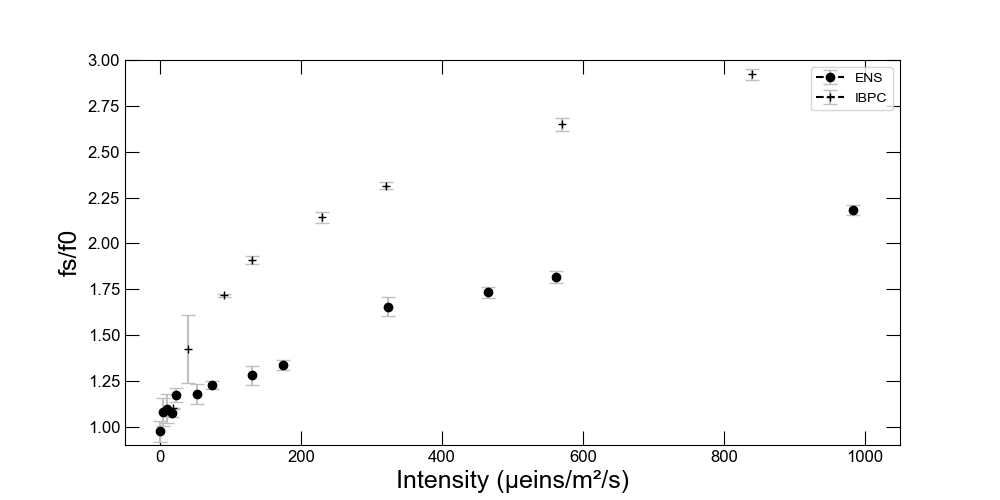

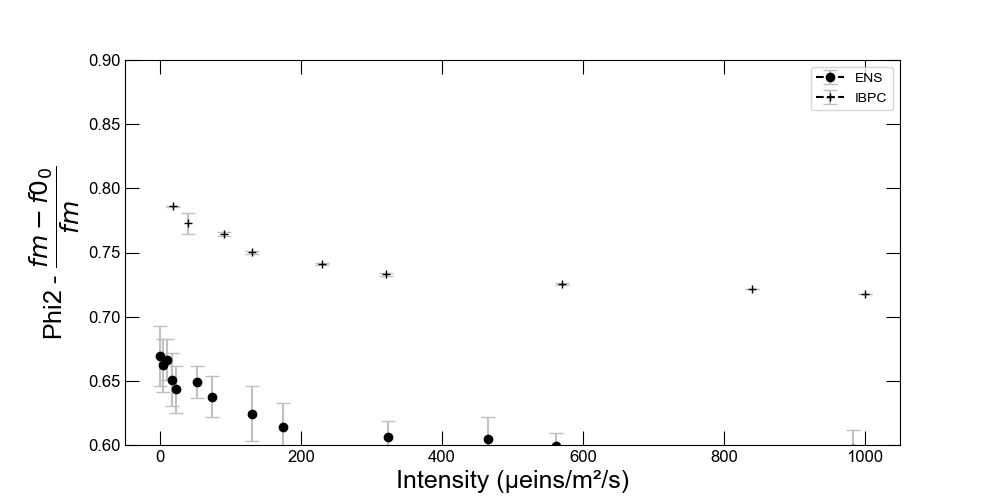

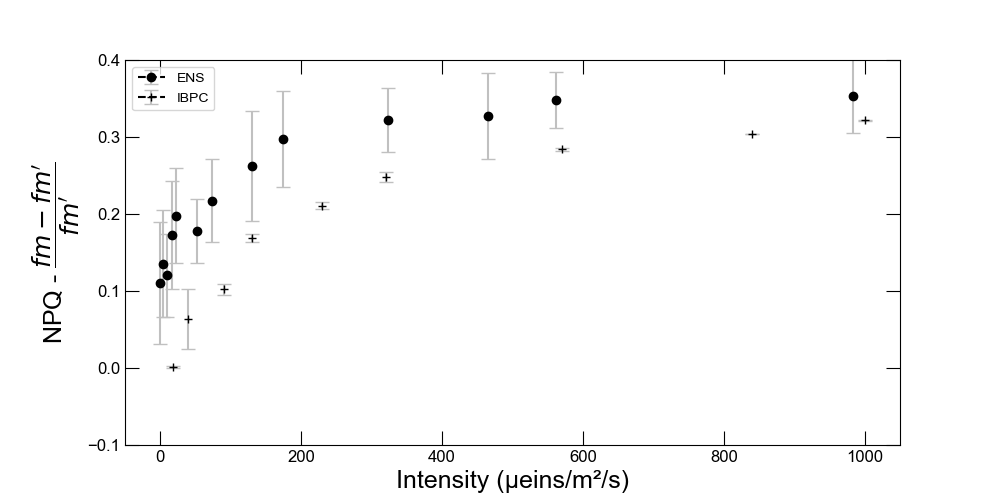

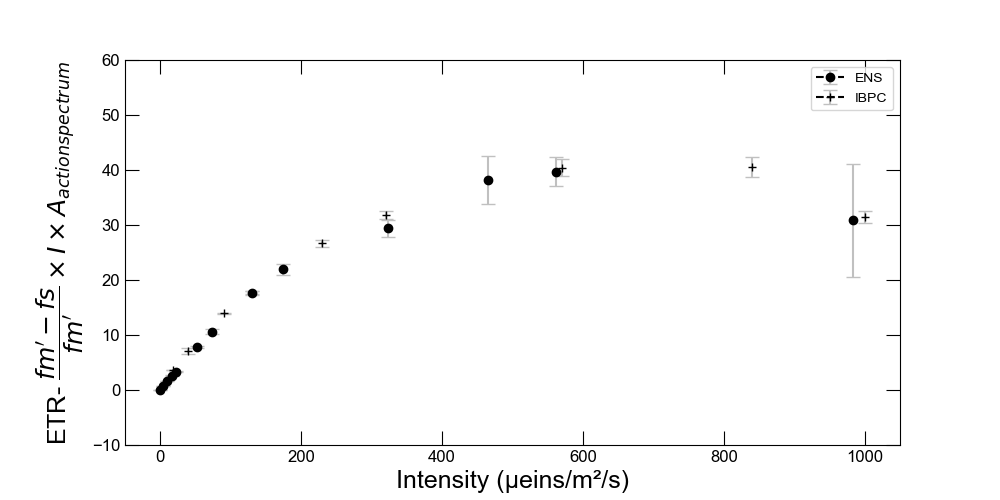

In [54]:

corrintensity = np.array(intensity_exp)*l480/l550
fmb = 1.6*fm
p.figsize=(10,5)
unite_units_dual(corrintensity, fm/fm[0], eintensity, efm/efm[0], r"fm'/fm", 0.7,1.05)
unite_units_dual(corrintensity, f0/f0[0], eintensity, ef0/ef0[0], r"f0'/f0", 0.9,1.5)
unite_units_dual(corrintensity, fs/f0[0], eintensity, efs/ef0[0], r"fs/f0", 0.9,3)
fig = unite_units_dual(corrintensity, ((fm-f0[0])/(fm)), eintensity, (efm-ef0[0])/efm, r"Phi2 - $\dfrac{fm-f0_0}{fm}$", 0.6, 0.9)
plt.savefig(p.save_folder + "/compare_phi2.pdf")
fig = unite_units_dual(corrintensity, (fm[0]-fm)/(fm), eintensity, (efm[0]-efm)/(efm), r"NPQ - $\dfrac{fm-fm'}{fm'}$", -0.1, 0.4)
plt.savefig(p.save_folder + "/compare_NPQ.pdf")
fig = unite_units_dual(corrintensity, (fm-fs)/fm*intensity_exp, eintensity, (efm-efs)/efm*eintensity*l550/100, r"ETR- $\dfrac{fm'-fs}{fm'}\times I \times A_{action spectrum}$", -10, 60)
plt.savefig(p.save_folder + "/compare_ETR.pdf")

In [ ]:
unite_units_dual(corrintensity, ((fm-f0)/(fm)), corrintensity,(fm[0]-fm)/fm, "Phi2", 0,0.6)
unite_units_dual( eintensity, (efm-ef0)/efm, eintensity, (efm[0]-efm)/efm, "Phi2", 0,0.9)


[3.23082662e-05 1.11003982e-02 3.78677338e-02]


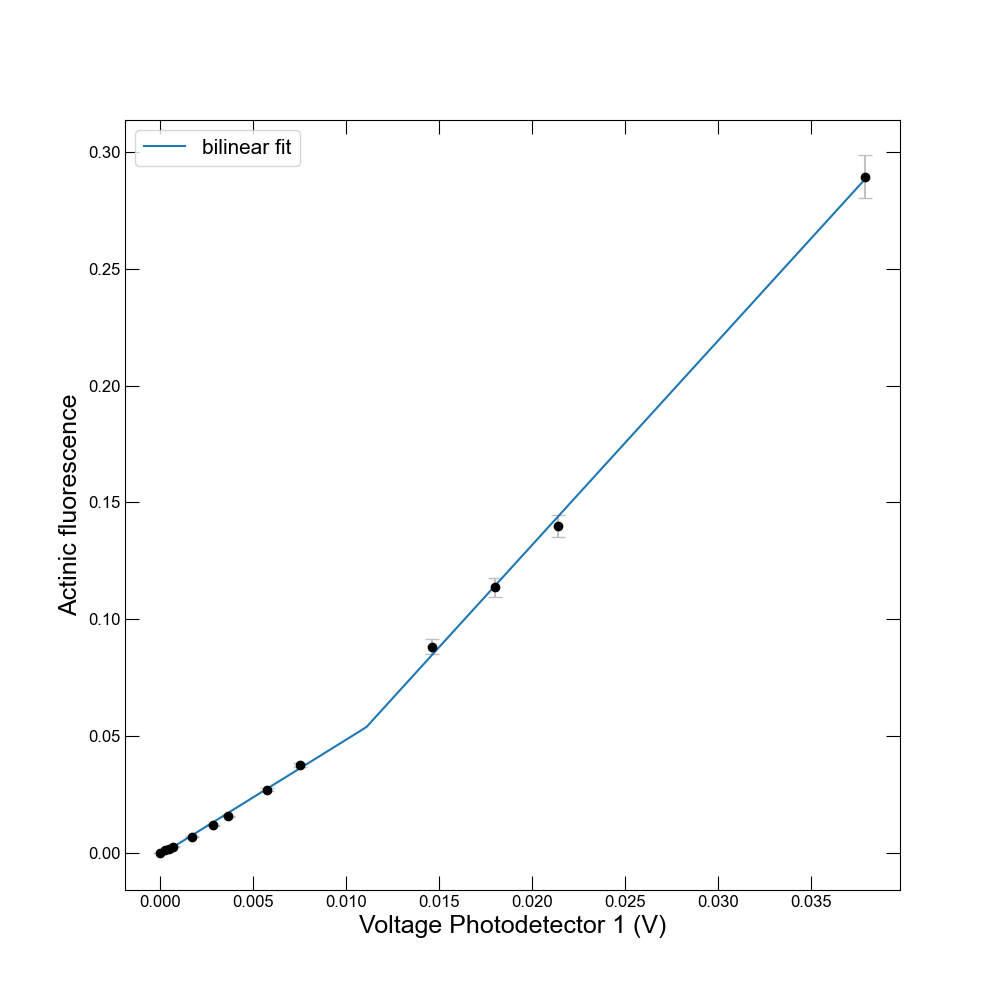

In [25]:
import pwlf

def multiline_fit(x, y):

    y = np.array([y for _, y in sorted(zip(x, y))])
    x = np.sort(x)

    my_pwlf = pwlf.PiecewiseLinFit(x, y)
    breaks = my_pwlf.fit(2)
    print(breaks)


    x_hat = np.linspace(x.min(), x.max(), 100)
    y_hat = my_pwlf.predict(x_hat)
                            
    return x_hat, y_hat, breaks


def unite_units(intensity_exp, ratio_val, ylabel):
    plt.close("all")
    intensities, positions = np.unique(intensity_exp, return_inverse=True)
    dic_val = {}
    for i, intens in enumerate(intensities):
        dic_val[intens] = []
        for k, pos in enumerate(positions): 
            if pos==i:
                dic_val[intens].append(ratio_val[k])
    
    fig = plt.figure(figsize = (10,10))   
    M = []
    I = []
    for j, k in enumerate(dic_val.keys()):
        m = np.mean(dic_val[k])
        M.append(m)
        I.append(k)
        s = np.std(dic_val[k])
        if k==0:
            plt.errorbar(k, m, s, capsize=5, ecolor="silver", fmt='--ok')
        else: 
            plt.errorbar(k, m, s, capsize=5, ecolor="silver", fmt='--ok')
    ax = plt.gca()
    
    x_hat, y_hat, breaks = multiline_fit(I, M)
    plt.plot(x_hat, y_hat, label = "bilinear fit")

    ax.tick_params(axis='both', which='major', labelsize= p.fonttick, direction = 'in', top = True, right = True, length = 10 )
    plt.xlabel("Voltage Photodetector 1 (V)", fontsize=p.fontsize)
    plt.ylabel(ylabel, fontsize = p.fontsize)
    plt.legend(prop={'size': 15})
    return fig

fig = unite_units(intensity_avg, fd1, "Actinic fluorescence")
plt.savefig(p.save_folder + "/Fluorescence_response_curve.pdf")


#### 